<a href="https://colab.research.google.com/github/karginb/classifications_with_tensorflow/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. Transfer Learning with TensorFlow Part 1: Feature Extraction
We've built a bunch of convolutional neural networks from scratch and they all seem to be learning, however, there is still plenty of room for improvement.

To improve our model(s), we could spend a while trying different configurations, adding more layers, changing the learning rate, adjusting the number of neurons per layer and more.

However, doing this is very time consuming.

Luckily, there's a technique we can use to save time.

It's called transfer learning, in other words, taking the patterns (also called weights) another model has learned from another problem and using them for our own problem.

There are two main benefits to using transfer learning:

Can leverage an existing neural network architecture proven to work on problems similar to our own.
Can leverage a working neural network architecture which has already learned patterns on similar data to our own. This often results in achieving great results with less custom data.
What this means is, instead of hand-crafting our own neural network architectures or building them from scratch, we can utilise models which have worked for others.

And instead of training our own models from scratch on our own datasets, we can take the patterns a model has learned from datasets such as ImageNet (millions of images of different objects) and use them as the foundation of our own. Doing this often leads to getting great results with less data.

Over the next few notebooks, we'll see the power of transfer learning in action.

## What we're going to cover
We're going to go through the following with TensorFlow:

* Introduce transfer learning (a way to beat all of our old self-built models)
* Using a smaller dataset to experiment faster (10% of training samples of 10 classes of food)
* Build a transfer learning feature extraction model using TensorFlow Hub
* Introduce the TensorBoard callback to track model training results
* Compare model results using TensorBoard


In [1]:
import datetime

print(datetime.datetime.now())

2023-11-04 10:59:19.200636


In [2]:
!nvidia-smi

Sat Nov  4 10:59:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Transfer leanring with TensorFlow Hub: Getting great results with 10% of the data
If you've been thinking, "surely someone else has spent the time crafting the right model for the job..." then you're in luck.

For many of the problems you'll want to use deep learning for, chances are, a working model already exists.

And the good news is, you can access many of them on TensorFlow Hub.

TensorFlow Hub is a repository for existing model components. It makes it so you can import and use a fully trained model with as little as a URL.

Now, I really want to demonstrate the power of transfer learning to you.

To do so, what if I told you we could get much of the same results (or better) than our best model has gotten so far with only 10% of the original data, in other words, 10x less data.

This seems counterintuitive right?

Wouldn't you think more examples of what a picture of food looked like led to better results?

And you'd be right if you thought so, generally, more data leads to better results.

However, what if you didn't have more data? What if instead of 750 images per class, you had 75 images per class?

Collecting 675 more images of a certain class could take a long time.

So this is where another major benefit of transfer learning comes in.

Transfer learning often allows you to get great results with less data.

But don't just take my word for it. Let's download a subset of the data we've been using, namely 10% of the training data from the 10_food_classes dataset and use it to train a food image classifier on.

## Downloading and becoming one with the data

In [3]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2023-11-04 10:59:25--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.126.207, 74.125.132.207, 74.125.201.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.126.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   235MB/s    in 0.7s    

2023-11-04 10:59:26 (235 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
import os

for dirpath,dirnames,filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/gr

## Creating data loaders (preparing the data)
Now we've downloaded the data, let's use the ImageDataGenerator class along with the flow_from_directory method to load in our images.

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
epoch = 5

train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"


train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size = (224, 224),
                                               batch_size = batch_size,
                                               class_mode = "categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = (224, 224),
                                             batch_size = batch_size,
                                             class_mode = "categorical")

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)
Before we build a model, there's an important concept we're going to get familiar with because it's going to play a key role in our future model building experiments.

And that concept is callbacks.

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks include:

* **Experiment tracking with TensorBoard** - log the performance of multiple models and then view and compare these models in a visual way on TensorBoard (a dashboard for inspecting neural network parameters). Helpful to compare the results of different models on your data.
* **Model checkpointing** - save your model as it trains so you can stop training if needed and come back to continue off where you left. Helpful if training takes a long time and can't be done in one sitting.
* **Early stopping** - leave your model training for an arbitrary amount of time and have it stop training automatically when it ceases to improve. Helpful when you've got a large dataset and don't know how long training will take.
We'll explore each of these overtime but for this notebook, we'll see how the TensorBoard callback can be used.

The TensorBoard callback can be accessed using tf.keras.callbacks.TensorBoard().

Its main functionality is saving a model's training performance metrics to a specified log_dir.

By default, logs are recorded every epoch using the update_freq='epoch' parameter. This is a good default since tracking model performance too often can slow down model training.

To track our modelling experiments using TensorBoard, let's create a function which creates a TensorBoard callback for us.

>🔑 Note: We create a function for creating a TensorBoard callback because as we'll see later on, each model needs its own TensorBoard callback instance (so the function will create a new one each time it's run).

In [6]:
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir = log_dir
  )
  print(f"Saving Tensorboard log file to: {log_dir}")
  return tensorboard_callback

Because you're likely to run multiple experiments, it's a good idea to be able to track them in some way.

In our case, our function saves a model's performance logs to a directory named [dir_name]/[experiment_name]/[current_timestamp], where:

* dir_name is the overall logs directory
* experiment_name is the particular experiment
* current_timestamp is the time the experiment started based on Python's datetime.datetime().now()

>🔑 Note: Depending on your use case, the above experimenting tracking naming method may work or you might require something more specific. The good news is, the TensorBoard callback makes it easy to track modelling logs as long as you specify where to track them. So you can get as creative as you like with how you name your experiments, just make sure you or your team can understand them

## Creating models using TensorFlow Hub
In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

In fact, we're going to use two models from TensorFlow Hub:

1. ResNetV2 - a state of the art computer vision model architecture from 2016.
2. EfficientNet - a state of the art computer vision architecture from 2019.
State of the art means that at some point, both of these models have achieved the lowest error rate on ImageNet (ILSVRC-2012-CLS), the gold standard of computer vision benchmarks.

You might be wondering, how do you find these models on TensorFlow Hub?

Here are the steps I took:

1. Go to tfhub.dev.
2. Choose your problem domain, e.g. "Image" (we're using food images).
3. Select your TF version, which in our case is TF2.
4. Remove all "Problem domanin" filters except for the problem you're working on.
* **Note**: "Image feature vector" can be used alongside almost any problem, we'll get to this soon.
5. The models listed are all models which could potentially be used for your problem.
>🤔 Question: I see many options for image classification models, how do I know which is best?

You can see a list of state of the art models on paperswithcode.com, a resource for collecting the latest in deep learning paper results which have code implementations for the findings they report.

Since we're working with images, our target are the models which perform best on ImageNet.

You'll probably find not all of the model architectures listed on paperswithcode appear on TensorFlow Hub. And this is okay, we can still use what's available.

To find our models, let's narrow down our search using the Architecture tab.

6. Select the Architecture tab on TensorFlow Hub and you'll see a dropdown menu of architecture names appear.
* The rule of thumb here is generally, names with larger numbers means better performing models. For example, EfficientNetB4 performs better than EfficientNetB0.
   * However, the tradeoff with larger numbers can mean they take longer to compute.
7.Select EfficientNetB0 and you should see something like the following:


8. Clicking the one titled "efficientnet/b0/feature-vector" brings us to a page with a button that says "Copy URL". That URL is what we can use to harness the power of EfficientNetB0.

Copying the URL should give you something like this: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1
🤔 Question: I thought we were doing image classification, why do we choose feature vector and not classification?

Great observation. This is where the differnet types of transfer learning come into play, as is, feature extraction and fine-tuning.

1. **"As is" transfer learning** is when you take a pretrained model as it is and apply it to your task without any changes.
* For example, many computer vision models are pretrained on the ImageNet dataset which contains 1000 different classes of images. This means passing a single image to this model will produce 1000 different prediction probability values (1 for each class).

  * This is helpful if you have 1000 classes of image you'd like to classify and they're all the same as the ImageNet classes, however, it's not helpful if you want to classify only a small subset of classes (such as 10 different kinds of food). Model's with "/classification" in their name on TensorFlow Hub provide this kind of functionality.
2. **Feature extraction transfer learning** is when you take the underlying patterns (also called weights) a pretrained model has learned and adjust its outputs to be more suited to your problem.
* For example, say the pretrained model you were using had 236 different layers (EfficientNetB0 has 236 layers), but the top layer outputs 1000 classes because it was pretrained on ImageNet. To adjust this to your own problem, you might remove the original activation layer and replace it with your own but with the right number of output classes. The important part here is that only the top few layers become trainable, the rest remain frozen.

  * This way all the underlying patterns remain in the rest of the layers and you can utilise them for your own problem. This kind of transfer learning is very helpful when your data is similar to the data a model has been pretrained on.
3. **Fine-tuning transfer learning** is when you take the underlying patterns (also called weights) of a pretrained model and adjust (fine-tune) them to your own problem.

  *  This usually means training some, many or all of the layers in the pretrained model. This is useful when you've got a large dataset (e.g. 100+ images per class) where your data is slightly different to the data the original model was trained on.

A common workflow is to "freeze" all of the learned patterns in the bottom layers of a pretrained model so they're untrainable. And then train the top 2-3 layers of so the pretrained model can adjust its outputs to your custom data (feature extraction).

After you've trained the top 2-3 layers, you can then gradually "unfreeze" more and more layers and run the training process on your own data to further fine-tune the pretrained model.

>🤔 Question: Why train only the top 2-3 layers in feature extraction?

The lower a layer is in a computer vision model as in, the closer it is to the input layer, the larger the features it learn. For example, a bottom layer in a computer vision model to identify images of cats or dogs might learn the outline of legs, where as, layers closer to the output might learn the shape of teeth. Often, you'll want the larger features (learned patterns are also called features) to remain, since these are similar for both animals, where as, the differences remain in the more fine-grained features

In [7]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import datetime

Now we'll get the feature vector URLs of two common computer vision architectures, EfficientNetB0 (2019) and ResNetV250 (2016) from TensorFlow Hub using the steps above.

We're getting both of these because we're going to compare them to see which performs better on our data.

> 🔑 Note: Comparing different model architecture performance on the same data is a very common practice. The simple reason is because you want to know which model performs best for your problem.

> Update: As of 14 August 2021, EfficientNet V2 pretrained models are available on TensorFlow Hub. The original code in this notebook uses EfficientNet V1, it has been left unchanged. In my experiments with this dataset, V1 outperforms V2. Best to experiment with your own data and see what suits you.

In [8]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

These URLs link to a saved pretrained model on TensorFlow Hub.

When we use them in our model, the model will automatically be downloaded for us to use.

To do this, we can use the KerasLayer() model inside the TensorFlow hub library.

Since we're going to be comparing two models, to save ourselves code, we'll create a function create_model(). This function will take a model's TensorFlow Hub URL, instatiate a Keras Sequential model with the appropriate number of output layers and return the model.

In [9]:
def create_model(model_url, num_classes=10):
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable = False,
                                           name = "feature_extraction_layer",
                                           input_shape = (224, 224, 3))


  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(10, activation = "softmax", name = "output_layer")

  ])


  return model

In [10]:
resnet_model = create_model(resnet_url, num_classes = 10)

resnet_model.compile(loss = "categorical_crossentropy",
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ["accuracy"])

In [11]:
resnet_history = resnet_model.fit(train_data,
                 epochs = 5,
                 steps_per_epoch = len(train_data),
                 validation_data = test_data,
                 validation_steps = len(test_data),
                 callbacks  = [create_tensorboard_callback(dir_name="tensorflow_hub",
                                                            experiment_name="resnet50V2")])

Saving Tensorboard log file to: tensorflow_hub/resnet50V2/20231104-110005
Epoch 1/5
24/24 [==============================] - 24s 559ms/step - loss: 1.9671 - accuracy: 0.3240 - val_loss: 1.2223 - val_accuracy: 0.6072
Epoch 2/5
24/24 [==============================] - 11s 451ms/step - loss: 0.9334 - accuracy: 0.7307 - val_loss: 0.8551 - val_accuracy: 0.7288
Epoch 3/5
24/24 [==============================] - 11s 468ms/step - loss: 0.6286 - accuracy: 0.8347 - val_loss: 0.7643 - val_accuracy: 0.7592
Epoch 4/5
24/24 [==============================] - 11s 480ms/step - loss: 0.4851 - accuracy: 0.8787 - val_loss: 0.7277 - val_accuracy: 0.7672
Epoch 5/5
24/24 [==============================] - 11s 463ms/step - loss: 0.3867 - accuracy: 0.9120 - val_loss: 0.6867 - val_accuracy: 0.7840


In [12]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  loss = history.history["loss"]
  accuracy = history.history["accuracy"]

  val_loss = history.history["val_loss"]
  val_accuracy = history.history["val_accuracy"]


  epochs = range(len(history.history["loss"]))

  plt.plot(epochs, loss, label = "Training Loss")
  plt.plot(epochs, val_loss, label = "Testing Loss")
  plt.title("loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()

  plt.plot(epochs, accuracy, label = "Training Accuracy")
  plt.plot(epochs, val_accuracy, label = "Testing Accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

  plt.show()



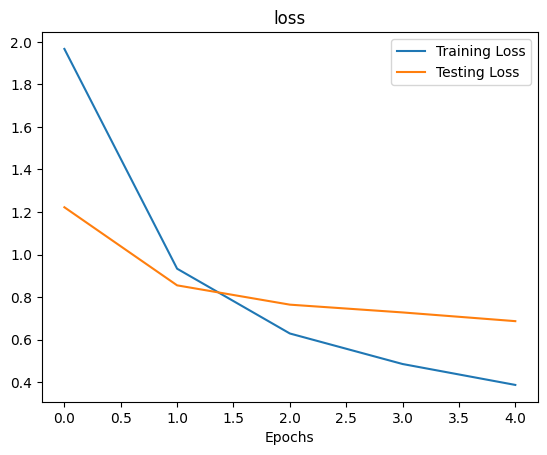

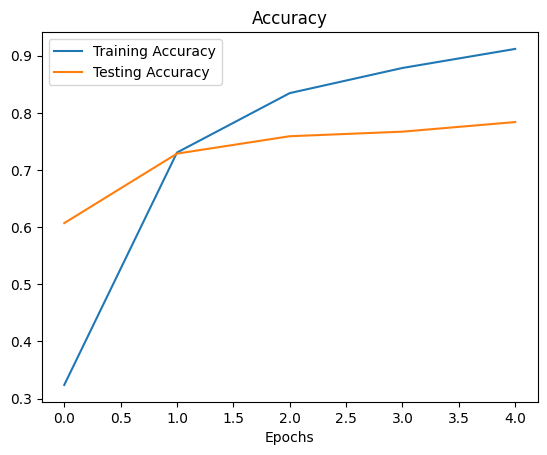

In [13]:
plot_loss_curves(resnet_history)

In [14]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


You can see the power of TensorFlow Hub here. The feature extraction layer has 23,564,800 parameters which are prelearned patterns the model has already learned on the ImageNet dataset. Since we set trainable=False, these patterns remain frozen (non-trainable) during training.

This means during training the model updates the 20,490 parameters in the output layer to suit our dataset.

Okay, we've trained a ResNetV250 model, time to do the same with EfficientNetB0 model.

The setup will be the exact same as before, except for the model_url parameter in the create_model() function and the experiment_name parameter in the create_tensorboard_callback() function.

In [15]:
efficientnet_model = create_model(efficientnet_url, 10)


efficientnet_model.compile(loss = "categorical_crossentropy",
                           optimizer = tf.keras.optimizers.Adam(),
                           metrics = ["accuracy"])


efficientnet_history = efficientnet_model.fit(train_data,
                       epochs = 5,
                       steps_per_epoch = len(train_data),
                       validation_data = test_data,
                       validation_steps = len(test_data),
                       callbacks = [create_tensorboard_callback("tensorflow_hub",
                                                                "efficientnetB0")]
                       )

Saving Tensorboard log file to: tensorflow_hub/efficientnetB0/20231104-110201
Epoch 1/5
24/24 [==============================] - 22s 524ms/step - loss: 1.8393 - accuracy: 0.4347 - val_loss: 1.3004 - val_accuracy: 0.7376
Epoch 2/5
24/24 [==============================] - 10s 425ms/step - loss: 1.0584 - accuracy: 0.7720 - val_loss: 0.8643 - val_accuracy: 0.8208
Epoch 3/5
24/24 [==============================] - 10s 427ms/step - loss: 0.7528 - accuracy: 0.8360 - val_loss: 0.6973 - val_accuracy: 0.8528
Epoch 4/5
24/24 [==============================] - 10s 422ms/step - loss: 0.6080 - accuracy: 0.8640 - val_loss: 0.6076 - val_accuracy: 0.8640
Epoch 5/5
24/24 [==============================] - 11s 453ms/step - loss: 0.5125 - accuracy: 0.8933 - val_loss: 0.5555 - val_accuracy: 0.8660


Holy smokes! The EfficientNetB0 model does even better than the ResNetV250 model! Achieving over 85% accuracy on the test set...again with only 10% of the training data.

How cool is that?

With a couple of lines of code we're able to leverage state of the art models and adjust them to our own use case.

Let's check out the loss curves.

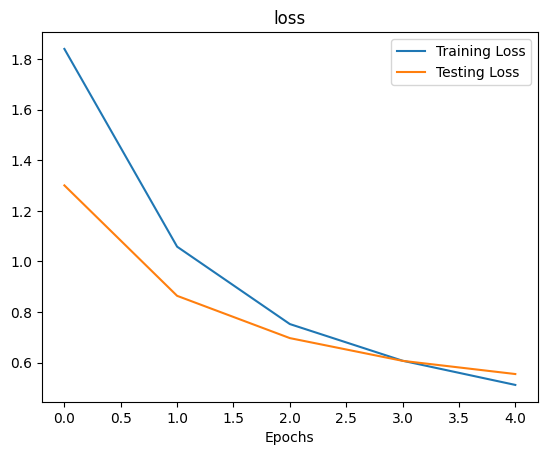

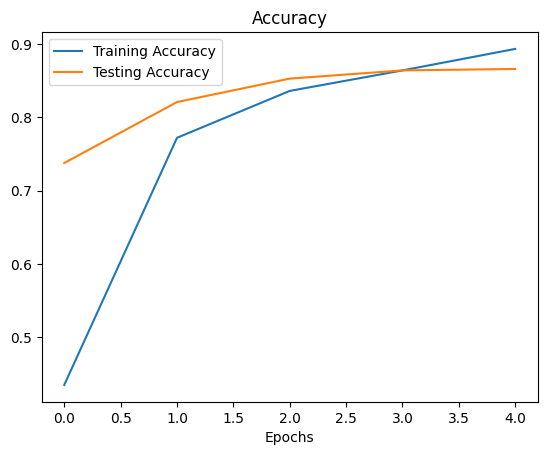

In [16]:
plot_loss_curves(efficientnet_history)

In [17]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


It seems despite having over four times less parameters (4,049,564 vs. 23,564,800) than the ResNet50V2 extraction layer, the EfficientNetB0 feature extraction layer yields better performance. Now it's clear where the "efficient" name came from.

In [18]:
imagenet_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"

In [19]:
imagenet_model = create_model(imagenet_url, 10)


imagenet_model.compile(loss = "categorical_crossentropy",
                       optimizer = tf.keras.optimizers.Adam(),
                       metrics = ["accuracy"])


imagenet_history = imagenet_model.fit(train_data,
                   epochs = 5,
                   steps_per_epoch = len(train_data),
                   validation_data= test_data,
                   validation_steps = len(test_data),
                   callbacks = [create_tensorboard_callback(
                      "tensorflow_hub",
                      "imagenetv2")])

Saving Tensorboard log file to: tensorflow_hub/imagenetv2/20231104-110317
Epoch 1/5
24/24 [==============================] - 20s 588ms/step - loss: 2.0091 - accuracy: 0.2987 - val_loss: 1.3005 - val_accuracy: 0.6076
Epoch 2/5
24/24 [==============================] - 10s 413ms/step - loss: 1.0643 - accuracy: 0.6933 - val_loss: 0.8915 - val_accuracy: 0.7420
Epoch 3/5
24/24 [==============================] - 10s 450ms/step - loss: 0.7458 - accuracy: 0.8053 - val_loss: 0.7393 - val_accuracy: 0.7788
Epoch 4/5
24/24 [==============================] - 13s 565ms/step - loss: 0.5918 - accuracy: 0.8427 - val_loss: 0.6752 - val_accuracy: 0.7956
Epoch 5/5
24/24 [==============================] - 10s 439ms/step - loss: 0.4907 - accuracy: 0.8760 - val_loss: 0.6322 - val_accuracy: 0.8072


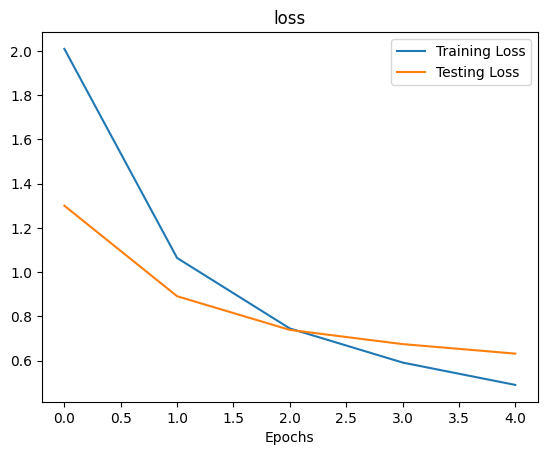

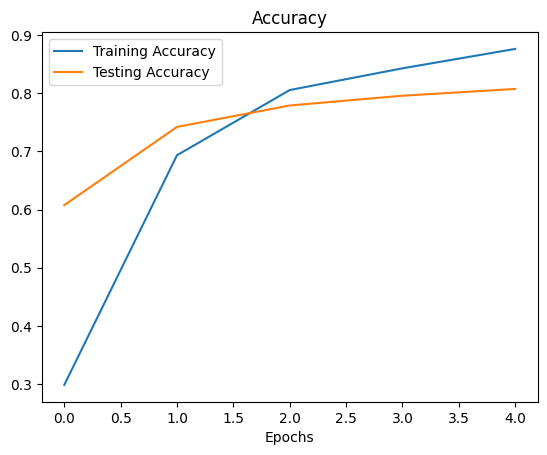

In [20]:
plot_loss_curves(imagenet_history)

In [21]:
imagenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              2257984   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 2270794 (8.66 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


## Comparing models using TensorBoard
Alright, even though we've already compared the performance of our two models by looking at the accuracy scores. But what if you had more than two models?

That's where an experiment tracking tool like TensorBoard (preinstalled in Google Colab) comes in.

The good thing is, since we set up a TensorBoard callback, all of our model's training logs have been saved automatically. To visualize them, we can upload the results to TensorBoard.dev.

Uploading your results to TensorBoard.dev enables you to track and share multiple different modelling experiments. So if you needed to show someone your results, you could send them a link to your TensorBoard.dev as well as the accompanying Colab notebook.

>🔑 Note: These experiments are public, do not upload sensitive data. You can delete experiments if needed.


## Uploading experiments to TensorBoard
To upload a series of TensorFlow logs to TensorBoard, we can use the following command:

Upload TensorBoard dev records

!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot



  Where:

* --logdir is the target upload directory
* --name is the name of the experiment
* --description is a brief description of the experiment
* --one_shot exits the TensorBoard uploader once uploading is finished

Running the tensorboard dev upload command will first ask you to authorize the upload to TensorBoard.dev. After you've authorized the upload, your log files will be uploaded.

In [28]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
 --name "EfficientNetB0 vs. ResNet50V2" \
 --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
 --one_shot

## Listing experiments you've saved to TensorBoard
To see all of the experiments you've uploaded you can use the command:

tensorboard dev list

In [ ]:
# uncomment to see
# !tensorboard dev list

## Deleting experiments from TensorBoard
Remember, all uploads to TensorBoard.dev are public, so to delete an experiment you can use the command:

tensorboard dev delete --experiment_id [INSERT_EXPERIMENT_ID]

In [26]:
#!tensorboard dev delete --experiment_id n6kd8XZ3Rdy1jSgSLH5WjA